## Optimization hyperparameters

### Batch size

Folk knowledge tells us to set powers of 2 for batch size $B = 16, 32, 64, ..., 512.$
Starting with $B = 32$ is recommended for image tasks {cite}`batch-size-32`.
Note that we may need to train with large batch sizes depending on the network architecture, the 
nature of the training distribution, or if we have large compute {cite}`imagenet1hour`.
Conversely, we may be forced to use small batches due to resource constraints with large models.

**Large batch.** 
Increasing $B$ with other parameters fixed can result in worse generalization ({numref}`02-large-batch-training`). This has been attributed to large batch size decreasing gradient noise {cite}`learning-rate-function-of-batch-size`.
Intuitively, less sampling noise means that we can use a larger learning rate, since the loss surface is more stable to different samples. Indeed, {cite}`imagenet1hour` suggests scaling up the learning rate
by the same factor that batch size is increased ({numref}`02-imagenet-1-hour`).


```{figure} ../../../img/nn/02-large-batch-training.png
---
name: 02-large-batch-training
width: 600px
---
{cite}`sharp_minima_bad` All models are trained in PyTorch using [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) 
with default parameters. Large batch training (LB) uses 10% of the dataset while small batch (SB) uses $B = 256$.
Recall that generalization gap reflects model bias and therefore is generally a 
function of network architecture. 
The table shows results for models that were not overfitted to the training distribution.
```

**Small batch.** This generally results in slow and unstable convergence since 
the loss surface is poorly approximated at each step. 
This is fixed by **gradient accumulation** 
which simulates a larger batch size by adding 
gradients from multiple small batches before performing a weight update.
Here accumulation step is increased by the same factor that batch size is 
decreased. This also means training takes longer by roughly the same factor.

```python
for i, batch in enumerate(train_loader):
    x, y = batch
    outputs = model(x)
    loss = loss_fn(y, outputs) / accumulation_steps
    loss.backward()

    if i % accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()
```

<br>

**Remark.** GPU is underutilized when $B$ is small, and we can get OOM when $B$ is large.
In general, hardware constraints should be considered in parallel with theory.
GPU can idle if there is lots of CPU processing on a large batch, for example. One can set 
`pin_device=True` can be set in the data loader to speed up data transfers to 
the GPU by leveraging [page locked memory](https://leimao.github.io/blog/Page-Locked-Host-Memory-Data-Transfer/). 
Similar tricks
({numref}`02-gpu-tricks`) have to be tested empirically to see whether it works on your
use-case. These are hard to figure out based on first principles. 

```{figure} ../../../img/nn/02-gpu-tricks.png
---
name: 02-gpu-tricks
width: 600px
---
A [tweet](https://twitter.com/karpathy/status/1299921324333170689?s=20) by Andrej Karpathy
on tricks to optimize Pytorch code. The linked [video](https://www.youtube.com/watch?v=9mS1fIYj1So).
```

### Learning rate

Finding an optimal learning rate is essential for both finding better minima and 
faster convergence. Based on our experiments, this is 
true even for optimizers that have adaptive learning rates such as Adam.
As discussed earlier, the choice of learning rate depends on the batch size. If we 
find a good base learning rate, and want to change the batch size, 
we have to scale the learning rate with the same factor {cite}`imagenet1hour` {cite}`learning-rate-function-of-batch-size`. 
This means smaller learning rate for smaller batches, and vice-versa ({numref}`02-imagenet-1-hour`).

In practice, we set a fixed batch size since this depends on certain hardware
constraints such as GPU efficiency and 
CPU processing code and implementation, as well as data transfer latency. Then, we proceed with 
learning rate tuning (i.e. a choice of base LR and decay policy).

```{figure} ../../../img/nn/02-imagenet-1-hour.png
---
name: 02-imagenet-1-hour
width: 500px
---
From {cite}`imagenet1hour`.  For all experiments 
$B \leftarrow aB$ and $\eta \leftarrow a\eta$
sizes are set. Note that a simple warmup phase for the first few epochs of
training until the learning rate stabilizes to $\eta$ since 
early steps are away from any minima, hence can be unstable. 
All other hyper-parameters are kept fixed. Using this
simple approach, accuracy of our models is invariant to minibatch
size (up to an 8k minibatch size). As an aside the authors were able to train
ResNet-50 on ImageNet in 1 hour using 256 GPUs. The scaling efficiency they obtained 
is 90% relative to the baseline of using 8 GPUs.
```

**LR finder.** The following is a parameter-free approach to finding a good base learning rate.
The idea is to select a base learning rate that is as large as possible without the loss diverging
at early steps of training.
This allows the optimizer to initially explore the surface with less risk of 
getting stuck in plateaus.

In [ ]:
from chapter import *

In [1]:
num_steps = 1000
lre_min = -2.0
lre_max =  0.6
lre = torch.linspace(lre_min, lre_max, num_steps)
lrs = 10 ** lre
w = nn.Parameter(torch.FloatTensor([-4.0, -4.0]), requires_grad=True)
optim = Adam([w], lr=lrs[0])

losses = []
for k in range(num_steps):
    optim.lr = lrs[k]   # (!) change LR at each step
    optim.zero_grad()
    loss = pathological_loss(w[0], w[1])
    loss.backward()
    optim.step()
    losses.append(loss.item())

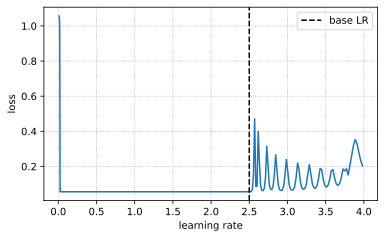

In [2]:
plt.figure(figsize=(6, 3.5))
plt.plot(lrs.detach(), losses)
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.grid(linestyle='dotted')
plt.axvline(2.5, color='k', linestyle='dashed', label='base LR')
plt.legend();

Notice that sampling is biased towards small learning rates. This makes sense since large learning rates tend to diverge. The graph is not representative for practical problems since the network is small and the loss surface is relatively simple. But following the algorithm, `lr=2.0` may be chosen as the base learning rate.

<br>

**LR scheduling.** Learning rate has to be decayed in some way help with convergence. 
Recall that this happens automatically using adaptive methods, but having a loss surface independent 
policy still helps, especially when given a predetermined computational budget.
The following modifies the training script to include a simple schedule. Repeating the same experiment above for RMSProp and GD which had issues with oscillation:

In [3]:
def train_curve(
    optim: OptimizerBase, 
    optim_params: dict, 
    w_init=[5.0, 5.0], 
    loss_fn=pathological_loss, 
    num_steps=100
):
    """Return trajectory of optimizer through loss surface from init point."""

    w_init = torch.tensor(w_init).float()
    w = nn.Parameter(w_init, requires_grad=True)
    optim = optim([w], **optim_params)
    points = [torch.tensor([w[0], w[1], loss_fn(w[0], w[1])])]
    
    for step in range(num_steps):
        optim.zero_grad()
        loss = loss_fn(w[0], w[1])
        loss.backward()
        optim.step()

        # logging
        with torch.no_grad():
            z = loss.unsqueeze(dim=0)
            points.append(torch.cat([w.data, z]))

        # LR schedule (!)
        if step % 70 == 0:
            optim.lr *= 0.5

    return torch.stack(points, dim=0).numpy()

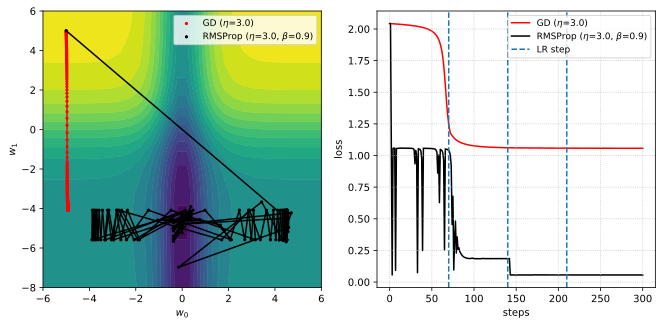

In [4]:
import chapter
chapter.train_curve = train_curve

fig, ax = plt.subplots(1, 2, figsize=(11, 5))
plot_gd_steps(ax, optim=GD,      optim_params={"lr": 3.0},              w_init=[-5.0, 5.0], label_map=label_map_gdm,     color="red")
plot_gd_steps(ax, optim=RMSProp, optim_params={"lr": 3.0, "beta": 0.9}, w_init=[-5.0, 5.0], label_map=label_map_rmsprop, color="black")

ax[0].set_xlim(-6, 6)
ax[0].set_ylim(-8, 6)
ax[1].set_xlabel("steps")
ax[1].set_ylabel("loss")
ax[1].axvline(70, linestyle='dashed')
ax[1].axvline(140, linestyle='dashed')
ax[1].axvline(210, linestyle='dashed', label='LR step', zorder=1)
ax[1].grid(linestyle="dotted", alpha=0.8)
ax[0].legend(fontsize=9)
ax[1].legend(fontsize=9);

Learning rate decay decreases GD oscillation drastically. The schedule $\boldsymbol{\boldsymbol{\Theta}}^{t+1} = \boldsymbol{\boldsymbol{\Theta}}^{t} - \eta \frac{1}{\alpha^t} \, \boldsymbol{\mathsf{m}}^{t}$ where $\alpha^t = 2^{\lfloor t / 100 \rfloor}$ is known as **step LR decay**. Note that this augments the second-moment for RMSProp which already auto-tunes the learning rate. Here we are able to start with a large learning rate allowing the optimizer to escape the first plateau earlier than before. Note that decay only decreases learning rate which can cause slow convergence. Some schedules implement **warm restarts** to fix this ({numref}`02-sgd-warm-restarts`).

**Remark.** For more examples of learning rate decay schedules [see here](https://d2l.ai/chapter_optimization/lr-scheduler.html#schedulers)  (e.g. **warmup** which initially gradually increases learning rate
since SGD at initialization can be unstable with large LR). Also see [PyTorch docs](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) on LR schedulers implemented in the library. For example, the schedule **reduce LR on plateau** which reduces the learning rate when a metric has stopped improving is implemented in PyTorch as `ReduceLROnPlateau` in the `torch.optim.lr_scheduler` library.

```python
# Example: PyTorch code for chaining LR schedulers
optim = SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler1 = ExponentialLR(optim, gamma=0.9)
scheduler2 = MultiStepLR(optim, milestones=[30,80], gamma=0.1)

for epoch in range(10):
    for x, y in dataset:
        optim.zero_grad()
        loss = loss_fn(model(x), y)
        loss.backward()
        optim.step()
    
    # LR step called after optimizer update! ⚠⚠⚠
    scheduler1.step()
    scheduler2.step()
```

<br>

```{figure} ../../../img/nn/02-sgd-warm-restarts.png
---
name: 02-sgd-warm-restarts
width: 60%
---
Cosine annealing starts with a large learning rate that is relatively rapidly decreased to a minimum value before being increased rapidly again. This resetting acts like a simulated restart of the model training and the re-use of good weights as the starting point of the restart is referred to as a "warm restart" in contrast to a "cold restart" at initialization. Source: {cite}`sgd-warm-restarts`
```

```{figure} ../../../img/nn/02-snapshot-ensembles.png
---
name: 02-snapshot-ensembles
width: 80%
---
Effect of cyclical learning rates. Each model checkpoint for each LR warm restart (which often correspond to a minimum) can be used to create an ensemble model. Source: {cite}`snapshot-ensembles`
```

### Momentum

Good starting values for SGD momentum are $\beta = 0.9$ or $0.99$. Adam is easier to use out of the box where we like to keep the default parameters. If we have resources, and we want to push test performance, we can
tune SGD which is known to generalize better than Adam with more epochs. See {cite}`sgd_better_than_adam` where it is shown that Adam is more stable at sharp minima which tend to generalize worse than flat ones ({numref}`02-sharp-optim`).

```{figure} ../../../img/nn/02-sharp-optim.png
---
name: 02-sharp-optim
width: 80%
---
A conceptual sketch of flat and sharp minima. The Y-axis indicates value of the loss
function and the X-axis the variables. Source: {cite}`sharp_minima_bad`
```

**Remark.** In principle, optimization hyperparameters affect training 
and not generalization. But the situation is more complex with SGD, where stochasticity
contributes to regularization. This was shown above where choice of batch size influences
the 
generalization gap. Also
recall that for batch GD (i.e. $B = N$ in SGD), consecutive gradients approaching a minimum 
roughly have the same direction. 
This should not happen with SGD with $B \ll N$ in the learning regime as different samples 
will capture different aspects of the loss surface.
Otherwise, the network is starting to overfit. So in practice, optimization hyperparameters 
are tuned on the validation set as well.